In [1]:
!pip install wordcloud
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.0 MB/s eta 0:00:00


In [2]:
#Import all libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

import string
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from gensim.models import Word2Vec, FastText
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
import gensim as gsm



In [3]:
# !pip install  gensim emoji
# !pip install gdown
# !gdown 1e_zLgwkt1LmmC2rY7DOaPgjwwC-p3h0F


In [4]:
# !wget https://github.com/uclnlp/emoji2vec/blob/master/pre-trained/emoji2vec.bin

In [5]:
emoji2vec_model = gsm.models.KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)
happy_vector = emoji2vec_model['😂']    # Produces an embedding vector of length 300

In [6]:
print(happy_vector)

[ 0.00368995 -0.00747812  0.04797658  0.0592004  -0.0594517  -0.01919357
  0.06628808 -0.06752758  0.10211562  0.087887   -0.02949324 -0.07718539
 -0.07068242  0.04688684 -0.07970048  0.09425059  0.06230384  0.09221437
 -0.03019106 -0.08475313  0.06153254  0.08948752  0.07492744 -0.0697182
  0.02842957 -0.07775956 -0.00585377 -0.01818646  0.07633407 -0.09874155
 -0.05507204  0.04539224  0.00842756 -0.06562244 -0.04902945 -0.05832005
  0.07070394  0.05070673  0.05466724  0.08123799  0.06764334 -0.09264724
  0.07862549 -0.03581576  0.02264971 -0.00622183 -0.0318586   0.0421854
 -0.05610641  0.07420981 -0.06671992 -0.05842454  0.03449175  0.07620545
  0.08768762  0.03041447 -0.05500258 -0.03190211  0.07291865 -0.04514114
 -0.0541351   0.05987531 -0.0346354  -0.01317827  0.00849659 -0.01372368
 -0.01279207 -0.01283779 -0.07702036  0.09149366  0.0390107   0.07108027
 -0.01238731  0.08397982 -0.08521689 -0.06615324  0.02603729  0.07916152
  0.08146766  0.09780202 -0.05352468  0.03703088  0.0

In [7]:
#!/usr/bin/env python
"""Wrapper for word2vec and emoji2vec models, so that we can query by entire phrase, rather than by
individual words.
"""

# External dependencies
import os.path
import gensim.models as gs
import numpy as np

# Authorship
__author__ = "Ben Eisner, Tim Rocktaschel"
__email__ = "beisner@princeton.edu"


class Phrase2Vec:
    """Wrapper for the word2vec model and emoji2vec model, allowing us to compute phrases"""
    def __init__(self, dim, w2v, e2v=None):
        """Constructor for the Phrase2Vec model

        Args:
            dim: Dimension of the vectors in word2vec and emoji2vec
            w2v: Gensim object for word2vec
            e2v: Gensim object for emoji2vec
        """
        self.wordVecModel = w2v
        if e2v is not None:
            self.emojiVecModel = e2v
        else:
            self.emojiVecModel = dict()
        self.dimension = dim

    @classmethod
    def from_word2vec_paths(cls, dim, w2v_path='/data/word2vec/GoogleNews-vectors-negative300.bin',
                            e2v_path=None):
        """Creates a Phrase2Vec object based on paths for w2v and e2v

        Args:
            dim: Dimension of the vectors in word2vec and emoji2vec
            w2v_path: Path to word2vec vectors
            e2v_path: Path to emoji2vec vectors

        Returns:

        """
        if not os.path.exists(w2v_path):
            print(str.format('{} not found. Either provide a different path, or download binary from '
                             'https://code.google.com/archive/p/word2vec/ and unzip', w2v_path))

        w2v = gs.KeyedVectors.load_word2vec_format(w2v_path, binary=True)
        # w2v = gs.Word2Vec.load(w2v_path)

        if e2v_path is not None:
            e2v = gs.KeyedVectors.load_word2vec_format(e2v_path, binary=True)
        else:
            e2v = dict()
        return cls(dim, w2v, e2v)

    def __getitem__(self, item):
        """Get the vector sum of all tokens in a phrase

        Args:
            item: Phrase to be converted into a vector sum

        Returns:
            phr_sum: Bag-of-words sum of the tokens in the phrase supplied
        """
        tokens = item.split(' ')
        phr_sum = np.zeros(self.dimension, np.float32)

        for token in tokens:
            if token in self.wordVecModel:
                phr_sum += self.wordVecModel[token]
            # elif token in self.emojiVecModel:
            #     phr_sum += self.emojiVecModel[token]

        return phr_sum

    def from_emoji(self, emoji_vec, top_n=10):
        """Get the top n closest tokens for a supplied emoji vector

        Args:
            emoji_vec: Emoji vector
            top_n: number of results to return

        Returns:
            Closest n tokens for a supplied emoji_vec
        """
        return self.wordVecModel.most_similar(positive=emoji_vec, negative=[], topn=top_n)

    def __setitem__(self, key, value):
        self.wordVecModel[key] = value

In [8]:
# Định nghĩa kích thước vector (thường là 300 cho Word2Vec)
vector_dim = 300

# Đường dẫn đến các mô hình
# word2vec_path = 'word2vec_dth_format.model'
word2vec_path = 'model_ug_cbow.bin'
emoji2vec_path = 'emoji2vec.bin'  # Nếu bạn có mô hình Emoji2Vec

phrase_vec = Phrase2Vec.from_word2vec_paths(dim=vector_dim, w2v_path=word2vec_path, e2v_path=emoji2vec_path)


In [9]:
phrase = "Chúc mừng sinh nhật "
vector = phrase_vec[phrase]
print(vector)

[ 2.30303238e-21  1.83709304e+30 -3.75142813e-34  4.38282276e-17
  3.38012182e-15  2.85253317e-27 -3.22268897e+22 -7.85050247e-07
 -1.55834074e-33 -1.50438516e-11  6.75233945e-19 -1.48046816e+08
  5.42367706e-10 -6.28765064e-17 -9.29730286e+02  1.08989879e-12
 -5.66106231e-04 -1.78913475e-28  7.35945897e+12  1.58292957e+03
  8.75439677e+27  7.29608384e+19 -3.87573389e+03 -1.31291490e+07
 -4.55010489e-29 -1.28462552e-09  1.60412409e+22  2.46086764e+20
 -3.58755165e-23  6.11737189e-11 -1.13918060e+07  2.44303124e-12
 -2.37353512e+35  3.28240230e-06  2.87767895e-37  1.10010747e+14
 -1.68497518e-34  1.46763437e-08 -5.95469112e-27  3.44506113e-35
 -7.07157085e+27  1.48350668e-19 -1.07912735e-19  4.81656443e-36
  5.14183123e+15 -5.61146344e-24  5.80420205e+21 -1.44949130e-13
 -3.56493938e+05 -4.41949256e-02  1.07119463e-19 -8.19918555e+03
  5.62363812e+05 -1.06252969e-06 -6.87892705e+23  1.09035064e-29
  5.66551180e-18  6.71628797e+31  5.20168972e+00  2.15985306e+02
  1.29877729e-03 -2.89899

In [10]:
#This function swaps 2 columns inside the dataframe
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [11]:
#This function removes punctuation from string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [12]:
#Reading dataset
emotion_dataset_train = pd.read_csv("UIT-VSFC_train_cleaned.csv")
emotion_dataset_test = pd.read_csv("UIT-VSFC_test_cleaned.csv")
emotion_dataset_val = pd.read_csv("UIT-VSFC_dev_cleaned.csv")

In [13]:
#Show dataset
emotion_dataset_train.head()

,sents,sentiments,tokens
0,slide giáo trình đầy đủ,2.0,"['slide', 'giáo trình', 'đầy đủ']"
1,nhiệt tình giảng dạy gần gũi với,2.0,"['nhiệt tình', 'giảng dạy', 'gần gũi', 'với']"
2,đi học đầy đủ full điểm chuyên cần,0.0,"['đi', 'học', 'đầy đủ', 'full điểm', 'chuyên',..."
3,chưa áp dụng công nghệ thông tin và các thiết ...,0.0,"['chưa', 'áp dụng', 'công nghệ thông tin', 'và..."
4,giảng bài hay có nhiều bài tập ví dụ ngay trên...,2.0,"['giảng bài', 'hay', 'có', 'nhiều', 'bài tập',..."


In [14]:
#Show dataset
emotion_dataset_test.head()

,sents,sentiments,tokens
0,nói tiếng anh lưu loát,2.0,"['nói', 'tiếng', 'anh', 'lưu loát']"
1,rất vui tính,2.0,"['rất', 'vui tính']"
2,có tâm,2.0,"['có', 'tâm']"
3,giảng bài thu hút dí dỏm,2.0,"['giảng', 'bài', 'thu hút', 'dí', 'dỏm']"
4,không giảng dạy kiến thức hướng dẫn thực hành ...,0.0,"['không', 'giảng dạy', 'kiến thức', 'hướng dẫn..."


In [15]:
#Show dataset
emotion_dataset_val.head()

,sents,sentiments,tokens
0,giáo trình chưa cụ thể,0.0,"['giáo trình', 'chưa', 'cụ thể']"
1,giảng buồn ngủ,0.0,"['giảng', 'buồn', 'ngủ']"
2,vui tính tận tâm,2.0,"['vui tính', 'tận tâm']"
3,nên giao bài tập nhiều hơn chia nhóm để làm bà...,0.0,"['nên', 'giao', 'bài tập', 'nhiều', 'hơn', 'ch..."
4,cần giảng bài chi tiết hơn đi sâu hơn code và ...,0.0,"['cần', 'giảng', 'bài', 'chi tiết', 'hơn', 'đi..."


In [16]:
stop here

SyntaxError: invalid syntax (1116318007.py, line 1)

In [31]:
emotion_dataset_train = emotion_dataset_train.drop('Unnamed: 0', axis=1)
emotion_dataset_test = emotion_dataset_test.drop('Unnamed: 0', axis=1)
emotion_dataset_val = emotion_dataset_val.drop('Unnamed: 0', axis=1)

In [32]:
emotion_dataset_train = swap_columns(emotion_dataset_train, 'Emotion', 'Sentence')
emotion_dataset_train.head()

,Sentence,Emotion
0,cho mình xin bài nhạc tên là gì với ạ,Other
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment


In [33]:
emotion_dataset_test = swap_columns(emotion_dataset_test, 'Emotion', 'Sentence')
emotion_dataset_test.head()

,Sentence,Emotion
0,người ta có bạn bè nhìn vui thật,Sadness
1,cho nghỉ viêc mói đúng sao goi là kỷ luật,Surprise
2,kinh vãi 😡,Disgust
3,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...,Fear
4,bố không thích nộp đấy mày thích ý kiến không,Anger


In [34]:
emotion_dataset_val = swap_columns(emotion_dataset_val, 'Emotion', 'Sentence')
emotion_dataset_val.head()

,Sentence,Emotion
0,"tính tao tao biết , chẳng có chuyện gì có thể ...",Other
1,"lại là lào cai , tự hào quê mình quá :))",Enjoyment
2,bị từ chối rồi,Sadness
3,tam đảo trời đẹp các mem à,Enjoyment
4,đọc bình luận của thằng đó không thiếu chữ nào 😂😂,Other


In [35]:
emotion_dataset_train = emotion_dataset_train.rename(columns={'Emotion': 'label'})
emotion_dataset_test = emotion_dataset_test.rename(columns={'Emotion': 'label'})
emotion_dataset_val = emotion_dataset_val.rename(columns={'Emotion': 'label'})

In [36]:
emotion_dataset_train["label"].value_counts()

label
Enjoyment    1558
Disgust      1071
Other        1021
Sadness       947
Anger         391
Fear          318
Surprise      242
Name: count, dtype: int64

In [37]:
df_plot = pd.concat([emotion_dataset_train, emotion_dataset_test, emotion_dataset_val], ignore_index=True)

df_plot.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6927 entries, 0 to 6926
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  6927 non-null   object
 1   label     6927 non-null   object
dtypes: object(2)
memory usage: 108.4+ KB


In [39]:
label_name = ['Tiêu cực', 'Trung Lập', 'Tích Cực']

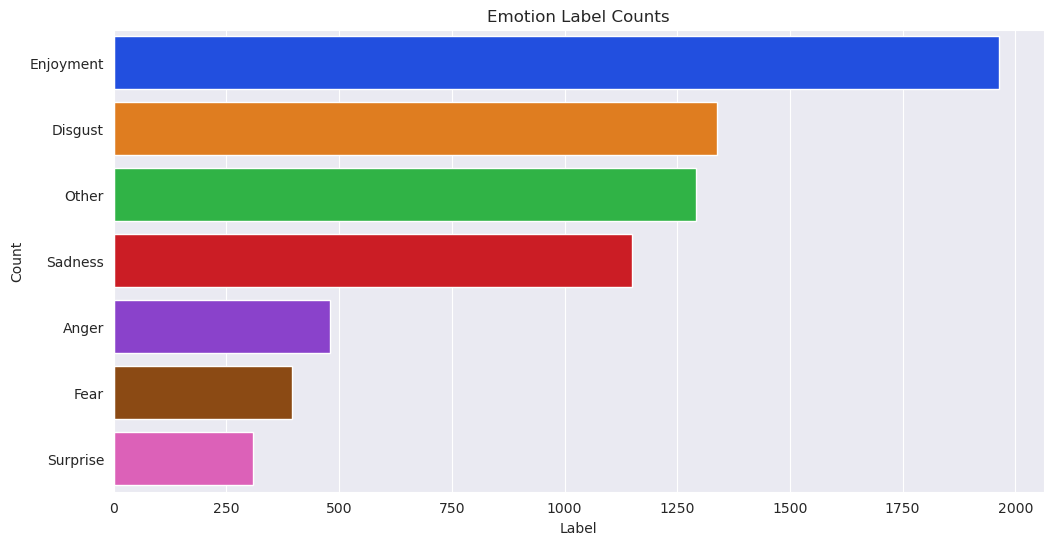

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_plot, 
              y='label', 
              order=df_plot['label'].value_counts().index,
              palette="bright")
plt.title("Emotion Label Counts")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

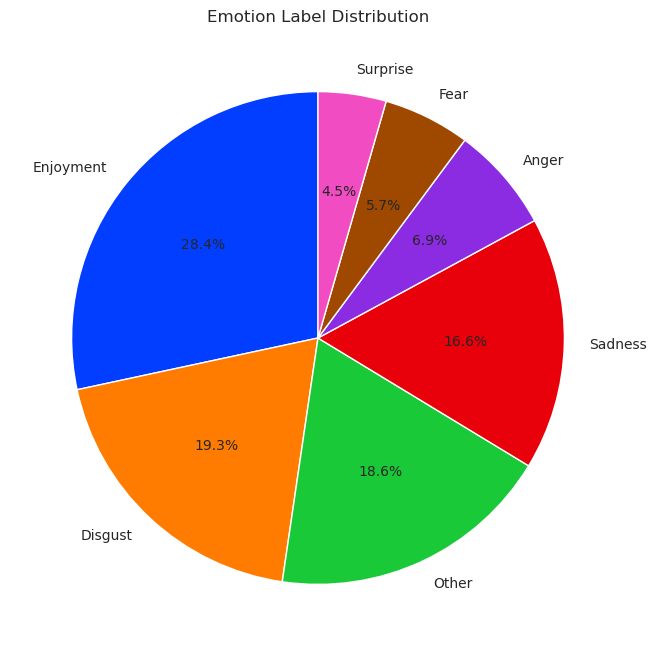

In [40]:
import matplotlib.pyplot as plt

# Tính tần suất các nhãn
label_counts = df_plot['label'].value_counts()

colors = sns.color_palette('bright')

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Emotion Label Distribution")
plt.show()


In [41]:
%pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [42]:
with open('vietnamese-stopwords.txt', 'r', encoding="utf-8") as f:
    stop_words = f.readlines()

In [43]:
print(f"Stop words size: {len(stop_words)}")

Stop words size: 1942


In [44]:
!pip install underthesea

In [17]:
X_train = emotion_dataset_train.iloc[:, 0].tolist()
X_test = emotion_dataset_test.iloc[:, 0].tolist()
X_val = emotion_dataset_val.iloc[:, 0].tolist()

In [18]:
y_train = emotion_dataset_train.iloc[:, 1].tolist()
y_test = emotion_dataset_test.iloc[:, 1].tolist()
y_val = emotion_dataset_val.iloc[:, 1].tolist()

In [19]:
print(len(X_test))

3166


In [20]:
print(len(y_test))

3166


In [49]:
import re
import string
from underthesea import word_tokenize
from underthesea import text_normalize
# Nếu chưa cài đặt underthesea, bạn có thể cài bằng lệnh:
# pip install underthesea

def preprocess_text_vietnamese(text):
    # 1. Chuyển về chữ thường
    text = text.lower()
    
    # 2. Loại bỏ dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Loại bỏ số
    text = re.sub(r'\d+', '', text)
    
    # 4. Loại bỏ khoảng trắng thừa
    text = text.strip()

    text = text_normalize(text)

    # 5. Tokenization bằng underthesea
    tokens = word_tokenize(text)
    
    tokens = [word for word in tokens if word not in stop_words]

    processed_text = ' '.join(tokens)
    
    return processed_text

# Áp dụng hàm cho dữ liệu
train_data_text_preprocessed_with_emoji = [preprocess_text_vietnamese(text) for text in X_train]
test_data_text_preprocessed_with_emoji = [preprocess_text_vietnamese(text) for text in X_test]
val_data_text_preprocessed_with_emoji = [preprocess_text_vietnamese(text) for text in X_val]

In [50]:
import re
import string
from underthesea import word_tokenize
from underthesea import text_normalize
# Nếu chưa cài đặt underthesea, bạn có thể cài bằng lệnh:
# pip install underthesea

def preprocess_text(text):
    # 1. Chuyển về chữ thường
    text = text.lower()
    
    # 2. Loại bỏ dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Loại bỏ số
    text = re.sub(r'\d+', '', text)
    
    # 4. Loại bỏ khoảng trắng thừa
    text = text.strip()

    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Biểu tượng & ký hiệu
        "\U0001F680-\U0001F6FF"  # Biểu tượng giao thông & bản đồ
        "\U0001F1E0-\U0001F1FF"  # Quốc kỳ
        "\U00002500-\U00002BEF"  # Các ký hiệu khác
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001F926-\U0001F937"
        "\U00010000-\U0010FFFF"  # Các ký hiệu bổ sung
        "\u200d"                 # Zero-width joiner
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"                 # Variation Selector
        "\u3030"
        "]+", 
        flags=re.UNICODE
    )
    
    text = re.sub(emoji_pattern, '', text)

    text = text_normalize(text)

    # 5. Tokenization bằng underthesea
    tokens = word_tokenize(text)
    
    tokens = [word for word in tokens if word not in stop_words]

    processed_text = ' '.join(tokens)

    return processed_text

# Áp dụng hàm cho dữ liệu
train_data_text_preprocessed = [preprocess_text(text) for text in X_train]
test_data_text_preprocessed = [preprocess_text(text) for text in X_test]
val_data_text_preprocessed = [preprocess_text(text) for text in X_val]

In [51]:
print(train_data_text_preprocessed)

['cho mình xin bài nhạc tên là gì với ạ', 'cho đáng đời con quỷ về nhà lôi con nhà mày ra mà đánh', 'lo học đi yêu đương lol gì hay lại thích học sinh học', 'ước gì sau này về già vẫn có thể như cụ này', 'mỗi lần có video của con là cứ coi đi coi lại hoài cưng con quá', 'thằng kia sao mày bắt vợ với bồ tao dọn thế kia nhà mày ở đâu tao đến thịt mày chết', 'một lí do trog muôn vàn lí do', 'thật hay đùa ác vậy không thể tin được', 'ko phải con mình mà xem còn thấy đau như vậy huống gì người trong cuộc thật là phẫn nộ mà cơ quan chức năng làm việc quá chậm trễ đến giờ mà vẫn chưa tìm ra người chịu trách nhiệm', 'per nghe đi rồi khóc trận cho thoải mái đừng cố gồng mình lên nữa', 'công nhận sáng tạo thật đấy', 'đòn tấn công cực gắt và cục sút của anh', 'trời nắng nóng thế này mình muốn bán nước không biết thu nhập có cao không ạ', 'minh biết nữa ne', 'mấy thằng củ lol việt nam nhảm nhí', 'tui thi ́ ch va ̉ i lă ́ mày ma ̀ ăn nhỉ ̀ u no ́ người lă ́ mày mọi người anh ̣ bi ̣ lơ ̉ miê ̣ người

In [21]:
def encode_phrase2vec(text, model):
    return model[text]

In [23]:
train_data_text_phrase_vec = [encode_phrase2vec(text, phrase_vec) for text in X_train]
test_data_text_phrase_vec = [encode_phrase2vec(text, phrase_vec) for text in X_test]
val_data_text_phrase_vec = [encode_phrase2vec(text, phrase_vec) for text in X_val]

In [24]:
train_data_text_phrase_vec = np.array(train_data_text_phrase_vec)
test_data_text_phrase_vec = np.array(test_data_text_phrase_vec)
val_data_text_phrase_vec = np.array(val_data_text_phrase_vec)
print(train_data_text_phrase_vec.shape)

(11423, 300)


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
train_data_text_tfidf = tfidf.fit_transform(X_train)
test_data_text_tfidf = tfidf.transform(X_test)
val_data_text_tfidf = tfidf.transform(X_val)

In [26]:
print(val_data_text_tfidf)

  (0, 168)	0.38212395456059584
  (0, 306)	0.4965475119495033
  (0, 452)	0.5449378201653188
  (0, 1472)	0.39882329051175885
  (0, 1543)	0.3891074489476824
  (1, 33)	0.672268648863527
  (1, 463)	0.3197915157425321
  (1, 1032)	0.6676737603158457
  (2, 1602)	0.45605525749828846
  (2, 1613)	0.5535094002631664
  (2, 1648)	0.4649462040545972
  (2, 1721)	0.5191011204608411
  (3, 36)	0.21731819626385743
  (3, 125)	0.24088806074503286
  (3, 308)	0.14123956378897973
  (3, 443)	0.24367843236300682
  (3, 463)	0.10887507036877773
  (3, 544)	0.18809664187985597
  (3, 592)	0.2800351523134629
  (3, 620)	0.202428844339536
  (3, 751)	0.17521259328705013
  (3, 788)	0.150866623746472
  (3, 918)	0.13780227606660192
  (3, 1044)	0.12010097777196864
  (3, 1068)	0.21903189568438436
  :	:
  (1580, 1681)	0.39336594598659325
  (1580, 1829)	0.4817071034062169
  (1581, 230)	0.35154804850930105
  (1581, 620)	0.1929904283419302
  (1581, 787)	0.15142726931856504
  (1581, 823)	0.17178285241016095
  (1581, 833)	0.2363844

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
countVector = CountVectorizer(ngram_range=(2,2))
train_data_text_count_vector = countVector.fit_transform(X_train)
test_data_text_count_vector = countVector.transform(X_test)
val_data_text_count_vector = countVector.transform(X_val)

In [28]:
print(val_data_text_count_vector)

  (0, 2191)	1
  (0, 4659)	1
  (0, 6531)	1
  (0, 22766)	1
  (1, 275)	1
  (1, 6705)	1
  (2, 23921)	1
  (2, 24271)	1
  (2, 25377)	1
  (3, 503)	2
  (3, 1487)	1
  (3, 4748)	1
  (3, 6432)	1
  (3, 6762)	1
  (3, 7940)	1
  (3, 8929)	1
  (3, 9162)	1
  (3, 10846)	1
  (3, 11498)	1
  (3, 13340)	1
  (3, 15087)	1
  (3, 15478)	1
  (3, 16195)	1
  (3, 16466)	1
  (3, 17302)	1
  :	:
  (1579, 23907)	1
  (1579, 24375)	1
  (1579, 25695)	1
  (1580, 1785)	1
  (1580, 2745)	1
  (1580, 5632)	1
  (1580, 10080)	1
  (1580, 15048)	1
  (1580, 23559)	1
  (1580, 25046)	1
  (1581, 9131)	1
  (1581, 11352)	1
  (1581, 12131)	1
  (1581, 12299)	1
  (1581, 13340)	1
  (1581, 13351)	1
  (1581, 15706)	1
  (1581, 20239)	1
  (1581, 22826)	1
  (1581, 23551)	2
  (1582, 5741)	1
  (1582, 7994)	1
  (1582, 21187)	1
  (1582, 26731)	1
  (1582, 27798)	1


In [48]:
# import torch
# from transformers import AutoModel, AutoTokenizer
#
# # Load model and tokenizer
# # Kiểm tra xem có GPU hay không, nếu có thì dùng GPU, nếu không thì dùng CPU
# device = torch.device("cpu")
#
# # Load model and tokenizer
# phobert_v2 = AutoModel.from_pretrained("vinai/phobert-base-v2").to(device)  # Chuyển mô hình sang GPU nếu có
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [56]:
print(val_data_text_preprocessed)

['tính tao tao biết chẳng có chuyện gì có thể làm tao phát điên cả', 'lại là lào cai tự hào quê mình quá', 'bị từ chối rồi', 'tam đảo trời đẹp các mem à', 'đọc bình luận của thằng đó không thiếu chữ nào', 'crush tao vẫn còn trinh nhé', 'nó nói không đúg ư đg của nhà bà ư nó đóg phí đg bộ còn nhà bà thì đóg thuế đất thôi đất nhà bà sử dụg được cả mặt đg cơ sao không mag ban ghế ra đấy mà kê', 'gap kiểu này chắc đái ra quần quá', 'yêu em mọa mọa', 'có ai như tao không đọc đề thì quen nhưng lại quên phương pháp giải chắc mất gốc rồi', 't cười ỉa', 'tao không biết tao đủ ổn để đi học thêm không nữa', 'làm chó khổ lắm chứ bộ', 'per hay xàm xàm mà zui hè', 'dm thể loại xàm lồn', 'loại không biết trân trọng những gì mik nhận được thì mãi mãi chỉ là những kẻ nghèo hèn bẩn thỉu', 'per thời mệ nội kho thịt ngon hí', 'bạn không có quyền đuổi người ta khó chịu thì gọi ca giao thông thôi bạn đuổi họ bạn sai lè lè', 'đôi khi cũng muốn dỗi lắm nhưng nghĩ lại đéo có người yêu mà dỗi', 'ngô ̀ i đo ̣ c 

In [59]:
import numpy as np

In [66]:
import sys
import numpy as np
print(sys.executable)
print(np.__version__)


/home/duycute/.conda/envs/python-310/bin/python
1.26.4


In [70]:
# from torch.utils.data import DataLoader, Dataset
#
# class TextDataset(Dataset):
#     def __init__(self, texts, tokenizer, max_length=128):
#         self.texts = texts
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#
#     def __len__(self):
#         return len(self.texts)
#
#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         encoded_input = self.tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_tensors='pt'
#         )
#         return encoded_input['input_ids'].squeeze()  # Shape: (max_length,)
#
# def encode_and_get_features_batch(data, tokenizer, phobert_v2, device, max_length=128, batch_size=16):
#     dataset = TextDataset(data, tokenizer, max_length)
#     dataloader = DataLoader(dataset, batch_size=batch_size)
#     features_list = []
#     for batch_input_ids in dataloader:
#         batch_input_ids = batch_input_ids.to(device)
#         with torch.no_grad():
#             outputs = phobert_v2(batch_input_ids)
#         last_hidden_states = outputs['last_hidden_state'].cpu().numpy()  # Shape: (batch_size, max_length, 768)
#
#         # Mean pooling trên trục sequence_length (trục 1)
#         pooled_features = np.mean(last_hidden_states, axis=1)  # Shape: (batch_size, 768)
#         features_list.append(pooled_features)
#     return np.vstack(features_list)  # Shape: (num_samples, 768)
#
# # Sử dụng hàm mới để trích xuất đặc trưng
# train_features_bert = encode_and_get_features_batch(train_data_text_preprocessed, tokenizer, phobert_v2, device)
# val_features_bert = encode_and_get_features_batch(val_data_text_preprocessed, tokenizer, phobert_v2, device)
# test_features_bert = encode_and_get_features_batch(test_data_text_preprocessed, tokenizer, phobert_v2, device)


KeyboardInterrupt: 

In [29]:
train_data = {
    'phrase_features': train_data_text_phrase_vec,
    'tfidf_features': train_data_text_tfidf,
    'bi_gram_features': train_data_text_count_vector,

}
test_data = {
    'phrase_features': test_data_text_phrase_vec,
    'tfidf_features': test_data_text_tfidf,
    'bi_gram_features': test_data_text_count_vector,
 
}
val_data = {
    'phrase_features': val_data_text_phrase_vec,
    'tfidf_features': val_data_text_tfidf,
    'bi_gram_features': val_data_text_count_vector,

}

In [34]:
import numpy as np
from sklearn.decomposition import PCA

# =========================
# 1) GHÉP & CHUYỂN TRAIN THÀNH DENSE
# =========================
train_phrase_dense = train_data['phrase_features']  # đã ở dạng numpy
train_tfid_dense   = train_data['tfidf_features'].toarray()  # từ csr_matrix -> numpy
train_bi_gram_dense= train_data['bi_gram_features'].toarray()  # từ csr_matrix -> numpy

# Ghép theo chiều cột (axis=1)
X_train_concat = np.concatenate([
    train_phrase_dense,
    train_tfid_dense,
    train_bi_gram_dense,
], axis=1)
print("X_train_concat shape:", X_train_concat.shape)

# =========================
# 2) FIT PCA TRÊN TRAIN & GIẢM CHIỀU
# =========================
pca = PCA(n_components=1024)  # tuỳ chọn số chiều mong muốn
X_train_dense = pca.fit_transform(X_train_concat)
print("X_train_dense shape sau PCA:", X_train_dense.shape)

# =========================
# 3) GHÉP & CHUYỂN TEST THÀNH DENSE
# =========================
test_phrase_dense = test_data['phrase_features']
test_tfid_dense   = test_data['tfidf_features'].toarray()
test_bi_gram_dense= test_data['bi_gram_features'].toarray()

X_test_concat = np.concatenate([
    test_phrase_dense,
    test_tfid_dense,
    test_bi_gram_dense,
], axis=1)
print("X_test_concat shape:", X_test_concat.shape)

# Áp dụng transform với PCA đã fit từ train
X_test_dense = pca.transform(X_test_concat)
print("X_test_dense shape sau PCA:", X_test_dense.shape)

# =========================
# 4) GHÉP & CHUYỂN VAL THÀNH DENSE
# =========================
val_phrase_dense = val_data['phrase_features']
val_tfid_dense   = val_data['tfidf_features'].toarray()
val_bi_gram_dense= val_data['bi_gram_features'].toarray()

X_val_concat = np.concatenate([
    val_phrase_dense,
    val_tfid_dense,
    val_bi_gram_dense,
], axis=1)
print("X_val_concat shape:", X_val_concat.shape)

X_val_dense = pca.transform(X_val_concat)
print("X_val_dense shape sau PCA:", X_val_dense.shape)


X_train_concat shape: (11423, 32251)
X_train_dense shape sau PCA: (11423, 1024)
X_test_concat shape: (3166, 32251)
X_test_dense shape sau PCA: (3166, 1024)
X_val_concat shape: (1583, 32251)
X_val_dense shape sau PCA: (1583, 1024)


In [35]:
print(len(y_train))

11423


In [70]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
# X_train_dense, y_train = sm.fit_resample(X_train_dense, y_train)

In [141]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
df_train, y_train = sm.fit_resample(df_train, y_train)

In [37]:
from sklearn.ensemble import RandomForestClassifier
import math
RF = RandomForestClassifier(n_estimators=400)
RF.fit(X_train_dense, y_train)
y_pred_RF_phrase= RF.predict(X_test_dense)
print(f'Accuracy on test set: {RF.score(X_test_dense, y_test)}')
#'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400


Accuracy on test set: 0.8114339861023373


Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

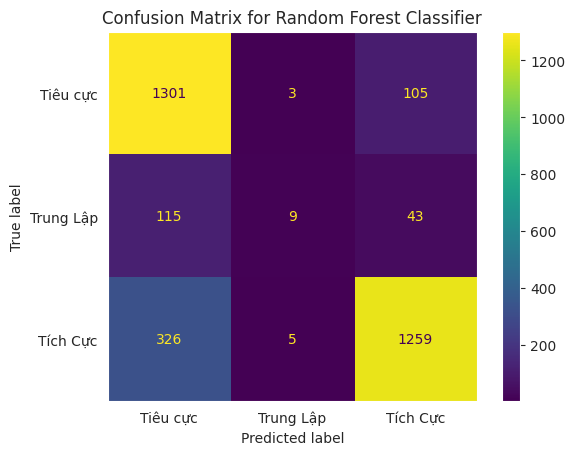

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_RF_phrase, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title("Confusion Matrix for Random Forest Classifier")

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_RF_phrase, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.75      0.92      0.83      1409
   Trung Lập       0.53      0.05      0.10       167
    Tích Cực       0.89      0.79      0.84      1590

    accuracy                           0.81      3166
   macro avg       0.72      0.59      0.59      3166
weighted avg       0.81      0.81      0.79      3166



In [46]:
from sklearn.neighbors import KNeighborsClassifier
KNC = KNeighborsClassifier(n_jobs=-1)
KNC.fit(X_train_dense, y_train)
y_pred_KNN = KNC.predict(X_test_dense)
print(f'Accuracy on test set: {KNC.score(X_test_dense, y_test)}')


Accuracy on test set: 0.7618445988629186


Text(0.5, 1.0, 'Confusion Matrix for K-Nearest Neighbors Classifier')

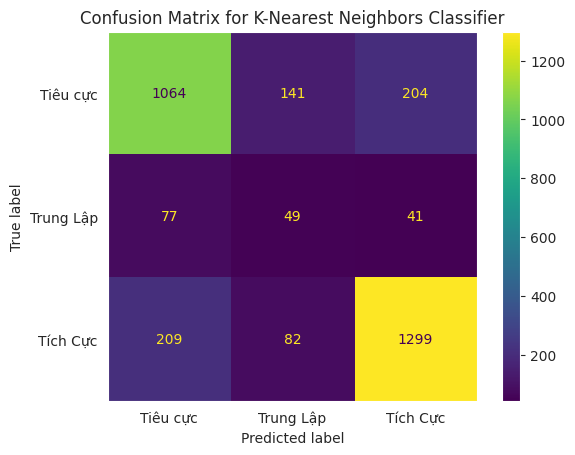

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_KNN, labels=KNC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title("Confusion Matrix for K-Nearest Neighbors Classifier")

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_KNN, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.79      0.76      0.77      1409
   Trung Lập       0.18      0.29      0.22       167
    Tích Cực       0.84      0.82      0.83      1590

    accuracy                           0.76      3166
   macro avg       0.60      0.62      0.61      3166
weighted avg       0.78      0.76      0.77      3166



In [49]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
GNB = GaussianNB(var_smoothing=1e-7)
GNB.fit(X_train_dense, y_train)
y_pred_GNB = GNB.predict(X_test_dense)
print(f'Accuracy on test set: {GNB.score(X_test_dense, y_test)}')


Accuracy on test set: 0.5467466835123184


Text(0.5, 1.0, 'Confusion Matrix for Gaussian Naive Bayes')

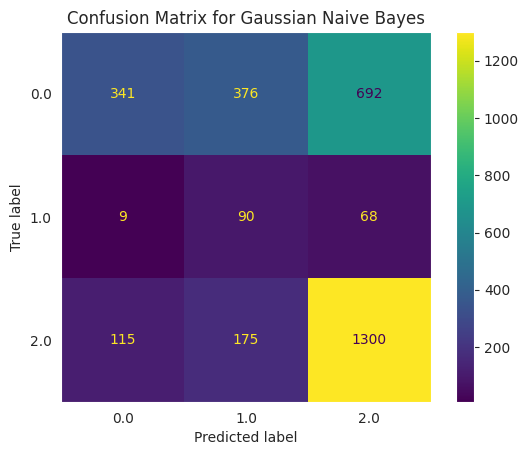

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_GNB, labels=GNB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GNB.classes_)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Gaussian Naive Bayes')

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_GNB, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.73      0.24      0.36      1409
   Trung Lập       0.14      0.54      0.22       167
    Tích Cực       0.63      0.82      0.71      1590

    accuracy                           0.55      3166
   macro avg       0.50      0.53      0.43      3166
weighted avg       0.65      0.55      0.53      3166



In [53]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.2 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 6.8 MB/s eta 0:00:0000:0100:01m


In [55]:
from sklearn.svm import SVC

# Khởi tạo mô hình với các tham số cụ thể
svc = SVC(

)

# Huấn luyện mô hình
svc.fit(X_train_dense, y_train)

# Dự đoán và đánh giá
y_pred_SVC = svc.predict(X_test_dense)
accuracy = svc.score(X_test_dense, y_test)
print(f'Accuracy on test set: {accuracy:.2f}')


Accuracy on test set: 0.86


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_SVC, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.81      0.95      0.87      1409
   Trung Lập       0.40      0.02      0.05       167
    Tích Cực       0.92      0.87      0.90      1590

    accuracy                           0.86      3166
   macro avg       0.71      0.61      0.60      3166
weighted avg       0.84      0.86      0.84      3166



Text(0.5, 1.0, 'Confusion Matrix for Support Vector Machine')

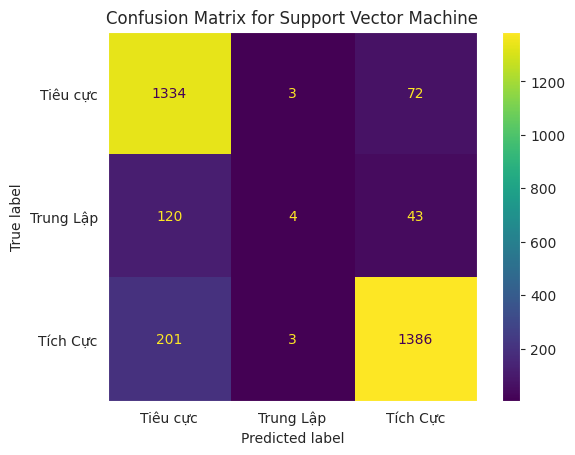

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_SVC, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Support Vector Machine')

In [59]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(
    max_iter=100000,     # Tăng số vòng lặp
    tol=1e-6,           # Giảm ngưỡng hội tụ
    random_state=2004,  # Sử dụng tất cả các CPU cores
)

# Huấn luyện mô hình
logistic_regression.fit(X_train_dense, y_train)

# Dự đoán
y_pred_logistic_regression = logistic_regression.predict(X_test_dense)

# Đánh giá mô hình
accuracy = logistic_regression.score(X_test_dense, y_test)
print(f'Accuracy on test set: {accuracy}')


Accuracy on test set: 0.8783954516740367


Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

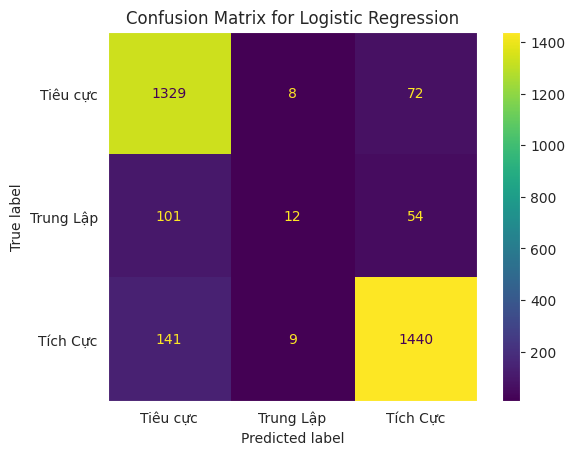

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_logistic_regression, labels=logistic_regression.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
disp.plot()
plt.gca().grid(False)
plt.title('Confusion Matrix for Logistic Regression')

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_logistic_regression, target_names=label_name))

              precision    recall  f1-score   support

    Tiêu cực       0.85      0.94      0.89      1409
   Trung Lập       0.41      0.07      0.12       167
    Tích Cực       0.92      0.91      0.91      1590

    accuracy                           0.88      3166
   macro avg       0.73      0.64      0.64      3166
weighted avg       0.86      0.88      0.86      3166

